3623
toggle_type
UI Flag            1666
Switches           1081
Runtime Feature     876
Name: count, dtype: int64


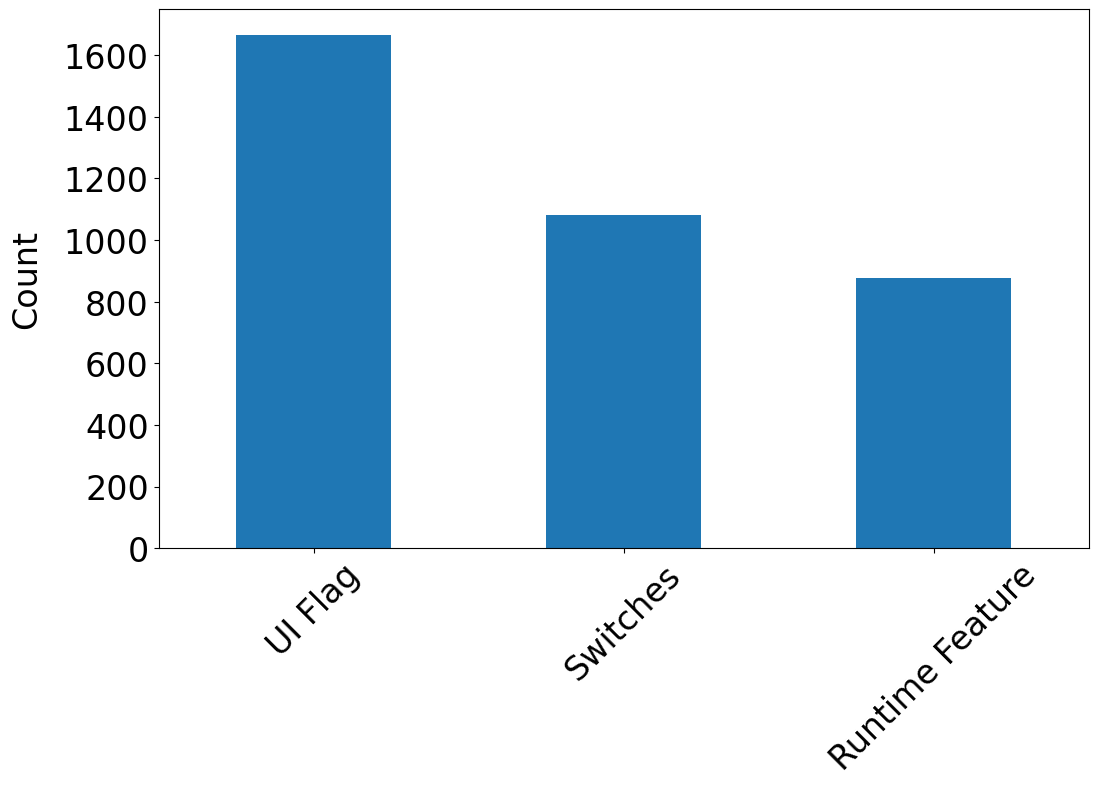

10412


In [28]:
import matplotlib.pyplot as plt
import pandas as pd
df =pd.read_csv('../../data/options_additions_removals.csv')
# Identify non-removed variables
df['removed'] = df['commit_date_removed'].notna()
df_not_removed = df[~df['removed']]

print(len(df_not_removed))
# Count variable types
variable_counts = df_not_removed['toggle_type'].value_counts()

print(variable_counts)
plt.figure(figsize=(12, 7))
variable_counts.plot(kind='bar')

# Set font sizes
plt.ylabel("Count", fontsize=24, labelpad=15)
plt.xticks(rotation=45, fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("")  # Remove x-axis label

plt.savefig('count.pdf', format='pdf', bbox_inches='tight')

# Show plot
plt.show()

print(len(df))


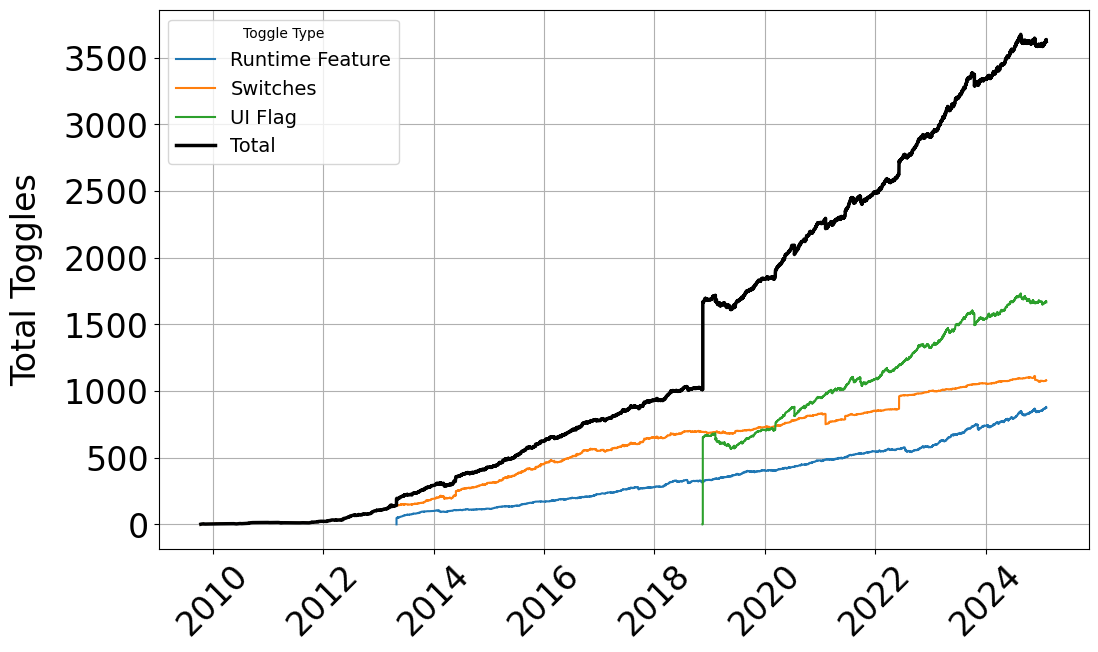

In [29]:

# Convert commit dates to datetime format
df['commit_date_added'] = pd.to_datetime(df['commit_date_added'], errors='coerce', utc=True)
df['commit_date_removed'] = pd.to_datetime(df['commit_date_removed'], errors='coerce', utc=True)

# Group data by toggle type and track their evolution over time

# Create a dataframe for additions and removals categorized by toggle type
toggle_changes_by_type = []

for toggle_type in df['toggle_type'].unique():
    df_type = df[df['toggle_type'] == toggle_type]

    # Additions
    additions = df_type[['commit_date_added']].rename(columns={'commit_date_added': 'date'})
    additions['change'] = 1
    additions['toggle_type'] = toggle_type

    # Removals
    removals = df_type[['commit_date_removed']].dropna().rename(columns={'commit_date_removed': 'date'})
    removals['change'] = -1
    removals['toggle_type'] = toggle_type

    # Combine both events
    toggle_changes_by_type.append(pd.concat([additions, removals]))

# Combine all toggle type data
toggle_changes_by_type = pd.concat(toggle_changes_by_type)

# Convert dates to datetime and remove timezone for proper plotting
toggle_changes_by_type['date'] = pd.to_datetime(toggle_changes_by_type['date'], utc=True).dt.tz_convert(None)

# Sort by date
toggle_changes_by_type = toggle_changes_by_type.sort_values(['toggle_type', 'date'])

# Compute cumulative sum to track evolution over time for each toggle type
toggle_changes_by_type['total_toggles'] = toggle_changes_by_type.groupby('toggle_type')['change'].cumsum()



# Compute overall toggle changes
toggle_changes_total = toggle_changes_by_type.groupby('date')['change'].sum().cumsum().reset_index()
toggle_changes_total['toggle_type'] = 'Total'

# Append the total toggles to the dataset for plotting
toggle_changes_with_total = pd.concat([toggle_changes_by_type, toggle_changes_total])

# Re-plot with total number included
plt.figure(figsize=(12, 7))

# Use a colormap for better distinction
colormap = plt.get_cmap("tab10")
toggle_types = toggle_changes_by_type['toggle_type'].unique()

for i, (toggle_type, data) in enumerate(toggle_changes_by_type.groupby('toggle_type')):
    plt.plot(data['date'], data['total_toggles'], label=toggle_type, color=colormap(i % 10))

# Add the total line in bold black for clear distinction
plt.plot(toggle_changes_total['date'], toggle_changes_total['change'], label='Total', color='black', linewidth=2.5)

# Formatting the plot
plt.ylabel("Total Toggles", fontsize=24, labelpad=15)
# plt.title("Evolution of the Number of Toggles Over Time by Type", fontsize=18, pad=15)
plt.xticks(rotation=45, fontsize=24)
plt.yticks(fontsize=24)
plt.legend(title="Toggle Type", fontsize=14)
plt.grid(True)

# Show the plot
plt.savefig('evolution.pdf', format='pdf', bbox_inches='tight')


In [30]:
# Define the target date for 2015
target_date = "2015-02-01"

# Ensure the target date is in datetime format
target_date = pd.to_datetime(target_date)

# Find the closest available date in the dataset before or on the target date
closest_date = toggle_changes_by_type[toggle_changes_by_type['date'] <= target_date]['date'].max()

# Retrieve the total number of toggles at that date
total_toggles_on_date = toggle_changes_by_type[toggle_changes_by_type['date'] == closest_date]['total_toggles'].sum()

# Display the result
closest_date, total_toggles_on_date


(Timestamp('2015-01-30 18:11:41'), 319)

In [31]:
# Count the total number of removed options
total_removed_options = df['commit_date_removed'].notna().sum()

# Display the result
total_removed_options


6789

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure commit dates are in datetime format
df['commit_date_added'] = pd.to_datetime(df['commit_date_added'], errors='coerce', utc=True)
df['commit_date_removed'] = pd.to_datetime(df['commit_date_removed'], errors='coerce', utc=True)

# Extract year and month from commit dates
df['year_month_added'] = df['commit_date_added'].dt.to_period('M')
df['year_month_removed'] = df['commit_date_removed'].dt.to_period('M')

# Count the number of added and removed toggles per month
added_per_month = df.groupby('year_month_added').size().reset_index(name='added_toggles')
removed_per_month = df.groupby('year_month_removed').size().reset_index(name='removed_toggles')

print('average addition per month:')
print(added_per_month['added_toggles'].mean())

print('average deletion per month:')
print(removed_per_month['removed_toggles'].mean())

# Merge the added and removed counts on the year-month
net_toggles_per_month = pd.merge(added_per_month, removed_per_month, 
                                 left_on='year_month_added', right_on='year_month_removed', 
                                 how='outer').fillna(0)

# Use the correct reference for time
net_toggles_per_month['year_month'] = net_toggles_per_month['year_month_added'].combine_first(net_toggles_per_month['year_month_removed'])

# Calculate the net number of toggles (added - removed)
net_toggles_per_month['net_toggles'] = net_toggles_per_month['added_toggles'] - net_toggles_per_month['removed_toggles']

# Keep only the relevant columns
net_toggles_per_month = net_toggles_per_month[['year_month', 'added_toggles', 'removed_toggles', 'net_toggles']]

# Convert period to datetime for proper plotting
net_toggles_per_month['year_month'] = net_toggles_per_month['year_month'].astype(str)
net_toggles_per_month = net_toggles_per_month[net_toggles_per_month['year_month'].str.match(r'\d{4}-\d{2}')]
net_toggles_per_month['year_month'] = pd.to_datetime(net_toggles_per_month['year_month'], format='%Y-%m')

# Find the first month where removals started
first_removal_date = net_toggles_per_month.loc[net_toggles_per_month['removed_toggles'] > 0, 'year_month'].min()

# Identify months where the net toggle difference is positive or negative
positive_diff_months = net_toggles_per_month[net_toggles_per_month['net_toggles'] > 0]
negative_diff_months = net_toggles_per_month[net_toggles_per_month['net_toggles'] < 0]

print("Months where more toggles were added than removed:")
print(positive_diff_months['year_month'].to_list())
print("\nMonths where more toggles were removed than added:")
print(negative_diff_months['year_month'].to_list())

# Count months where net toggles are positive and negative
positive_months = len(positive_diff_months)
negative_months = len(negative_diff_months)

print(f"\nNumber of months with more added toggles: {positive_months}")
print(f"Number of months with more removed toggles: {negative_months}")

# Plot the number of added and removed toggles per month
plt.figure(figsize=(16, 7))
plt.plot(net_toggles_per_month['year_month'], net_toggles_per_month['added_toggles'], marker='o', linestyle='-', color='g', linewidth=2, label='Added Toggles')
plt.plot(net_toggles_per_month['year_month'], -net_toggles_per_month['removed_toggles'], marker='o', linestyle='-', color='r', linewidth=2, label='Removed Toggles')

print(first_removal_date)

# Formatting the plot for better readability
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Reference line at y=0
plt.xlabel(" ", fontsize=24, labelpad=10)
plt.ylabel("Number of Toggles", fontsize=24, labelpad=10)
plt.xticks(rotation=45, fontsize=24)
plt.yticks(fontsize=24)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig('adds_vs_removals.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()



/var/folders/jk/m520gmtj3bb3wx6g5vj9bffw0000gp/T/ipykernel_43280/2644237198.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month_added'] = df['commit_date_added'].dt.to_period('M')
/var/folders/jk/m520gmtj3bb3wx6g5vj9bffw0000gp/T/ipykernel_43280/2644237198.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month_removed'] = df['commit_date_removed'].dt.to_period('M')


average addition per month:
58.824858757062145
average deletion per month:
39.93529411764706
Months where more toggles were added than removed:
[Timestamp('2009-10-01 00:00:00'), Timestamp('2009-12-01 00:00:00'), Timestamp('2010-01-01 00:00:00'), Timestamp('2010-05-01 00:00:00'), Timestamp('2010-06-01 00:00:00'), Timestamp('2010-08-01 00:00:00'), Timestamp('2010-09-01 00:00:00'), Timestamp('2010-11-01 00:00:00'), Timestamp('2011-02-01 00:00:00'), Timestamp('2011-04-01 00:00:00'), Timestamp('2011-08-01 00:00:00'), Timestamp('2011-10-01 00:00:00'), Timestamp('2011-11-01 00:00:00'), Timestamp('2011-12-01 00:00:00'), Timestamp('2012-01-01 00:00:00'), Timestamp('2012-02-01 00:00:00'), Timestamp('2012-04-01 00:00:00'), Timestamp('2012-05-01 00:00:00'), Timestamp('2012-06-01 00:00:00'), Timestamp('2012-07-01 00:00:00'), Timestamp('2012-08-01 00:00:00'), Timestamp('2012-09-01 00:00:00'), Timestamp('2012-10-01 00:00:00'), Timestamp('2012-11-01 00:00:00'), Timestamp('2012-12-01 00:00:00'), Times

{'Mean': 20.497175141242938, 'Median': 13.0, 'Min': -66.0, 'Max': 670.0, 'Average Additions': 58.824858757062145, 'Average Removals': 38.32768361581921}


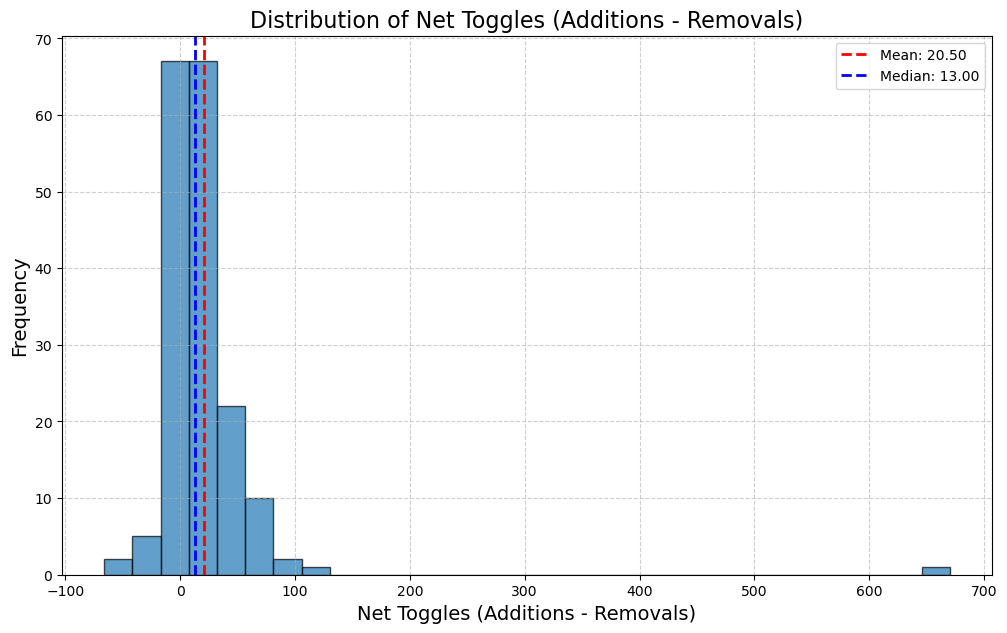

In [33]:
# Calculate summary statistics for the net number of toggles (added - removed)
net_toggles_stats = {
    "Mean": net_toggles_per_month['net_toggles'].mean(),
    "Median": net_toggles_per_month['net_toggles'].median(),
    "Min": net_toggles_per_month['net_toggles'].min(),
    "Max": net_toggles_per_month['net_toggles'].max()
}

# Display the summary statistics
net_toggles_stats_df = pd.DataFrame.from_dict(net_toggles_stats, orient='index', columns=['Value'])


avg_additions = net_toggles_per_month['added_toggles'].mean()
avg_removals = net_toggles_per_month['removed_toggles'].mean()

# Update summary statistics
net_toggles_stats.update({
    "Average Additions": avg_additions,
    "Average Removals": avg_removals
})

print(net_toggles_stats)

# Plot the distribution of additions - removals
plt.figure(figsize=(12, 7))
plt.hist(net_toggles_per_month['net_toggles'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(net_toggles_per_month['net_toggles'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {net_toggles_per_month['net_toggles'].mean():.2f}")
plt.axvline(net_toggles_per_month['net_toggles'].median(), color='blue', linestyle='dashed', linewidth=2, label=f"Median: {net_toggles_per_month['net_toggles'].median():.2f}")

# Formatting the plot
plt.xlabel("Net Toggles (Additions - Removals)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Net Toggles (Additions - Removals)", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [34]:
# Group data by toggle type and year-month for additions and removals
added_per_month_by_type = df.groupby(['toggle_type', 'year_month_added']).size().reset_index(name='added_toggles')
removed_per_month_by_type = df.groupby(['toggle_type', 'year_month_removed']).size().reset_index(name='removed_toggles')

# Merge the added and removed counts on year-month and toggle type
net_toggles_per_month_by_type = pd.merge(added_per_month_by_type, removed_per_month_by_type, 
                                         left_on=['toggle_type', 'year_month_added'], 
                                         right_on=['toggle_type', 'year_month_removed'], 
                                         how='outer').fillna(0)

# Use the correct reference for time
net_toggles_per_month_by_type['year_month'] = net_toggles_per_month_by_type['year_month_added'].combine_first(net_toggles_per_month_by_type['year_month_removed'])

# Calculate the net number of toggles (added - removed) for each type
net_toggles_per_month_by_type['net_toggles'] = net_toggles_per_month_by_type['added_toggles'] - net_toggles_per_month_by_type['removed_toggles']

# Keep only relevant columns
net_toggles_per_month_by_type = net_toggles_per_month_by_type[['toggle_type', 'year_month', 'added_toggles', 'removed_toggles', 'net_toggles']]

# Convert period to datetime for plotting
net_toggles_per_month_by_type['year_month'] = net_toggles_per_month_by_type['year_month'].astype(str)
net_toggles_per_month_by_type = net_toggles_per_month_by_type[net_toggles_per_month_by_type['year_month'].str.match(r'\d{4}-\d{2}')]
net_toggles_per_month_by_type['year_month'] = pd.to_datetime(net_toggles_per_month_by_type['year_month'], format='%Y-%m')

# Get unique toggle types
toggle_types = net_toggles_per_month_by_type['toggle_type'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=len(toggle_types), ncols=1, figsize=(12, 7 * len(toggle_types)))

# Perform analysis for each toggle type
summary_stats = []

for i, toggle_type in enumerate(toggle_types):
    data = net_toggles_per_month_by_type[net_toggles_per_month_by_type['toggle_type'] == toggle_type]

    # Compute statistics
    stats = {
        "Toggle Type": toggle_type,
        "Mean": data['net_toggles'].mean(),
        "Median": data['net_toggles'].median(),
        "Min": data['net_toggles'].min(),
        "Max": data['net_toggles'].max(),
        "Average Additions": data['added_toggles'].mean(),
        "Average Removals": data['removed_toggles'].mean()
    }
    summary_stats.append(stats)

    # Plot each toggle type
    ax = axes[i] if len(toggle_types) > 1 else axes

    ax.plot(data['year_month'], data['added_toggles'], marker='o', linestyle='-', color='g', linewidth=2, label='Added Toggles')
    ax.plot(data['year_month'], -data['removed_toggles'], marker='o', linestyle='-', color='r', linewidth=2, label='Removed Toggles')

    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Reference line at y=0
    ax.set_xlabel("Year-Month", fontsize=14, labelpad=10)
    ax.set_ylabel("Number of Toggles", fontsize=14, labelpad=10)
    ax.set_title(f"Added vs Removed Toggles for {toggle_type}", fontsize=16, pad=15)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Extend the analysis to count months where additions > removals and vice versa
for stats in summary_stats:
    toggle_type = stats["Toggle Type"]
    data = net_toggles_per_month_by_type[net_toggles_per_month_by_type['toggle_type'] == toggle_type]
    
    # Count months where net toggles are positive and negative
    stats["Months with More Additions"] = (data['net_toggles'] > 0).sum()
    stats["Months with More Removals"] = (data['net_toggles'] < 0).sum()

# Update and display the summary table
summary_stats_df = pd.DataFrame(summary_stats)
print(summary_stats_df)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


       Toggle Type       Mean  Median   Min    Max  Average Additions  \
0  Runtime Feature   6.125874     5.0 -24.0   49.0          18.482517   
1         Switches   6.135593     5.0 -65.0  103.0          14.259887   
2          UI Flag  21.921053    17.0 -81.0  667.0          69.013158   

   Average Removals  Months with More Additions  Months with More Removals  
0         12.356643                         118                         17  
1          8.124294                         141                         20  
2         47.092105                          55                         20  


6789
                             commit_id_removed  removed_toggles
3996  c5e0d31864b10faa0bc1cd25be979c19e95ee638               80
4903  f3fbcea2faf0d3e193ffd0412f799a34f05daeaf               77
924   2e46fdc8a6cb36ffe2c974d653a06bb5aee70fff               69
1655  534046c57b05b45d3cfa15d9d29d44b9f3486d77               46
4215  d032860f8a813913358a2e28dfef03ab2230977f               31
                                    Value
Mean                             1.313407
Median                           1.000000
Min                              1.000000
Max                             80.000000
Commits with Multiple Removals   7.000000


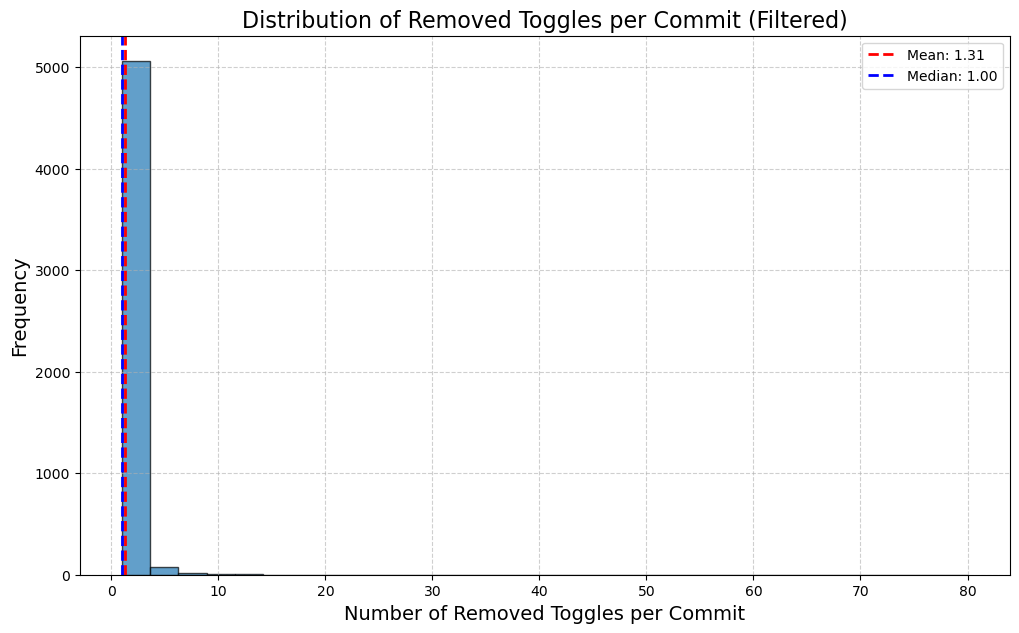

In [42]:
# Remove rows where commit_id_removed is null
df_removed = df.dropna(subset=['commit_id_removed'])

print(len(df_removed))
# Count the number of removed toggles per commit
removed_toggles_per_commit = df_removed.groupby('commit_id_removed').size().reset_index(name='removed_toggles')

top_removal_changes = removed_toggles_per_commit.sort_values(by='removed_toggles', ascending=False).head(5)
print(top_removal_changes)

# Compute summary statistics
removed_toggles_stats = {
    "Mean": removed_toggles_per_commit['removed_toggles'].mean(),
    "Median": removed_toggles_per_commit['removed_toggles'].median(),
    "Min": removed_toggles_per_commit['removed_toggles'].min(),
    "Max": removed_toggles_per_commit['removed_toggles'].max(),
    "Commits with Multiple Removals": (removed_toggles_per_commit['removed_toggles'] >= 20).sum()
}

# Display the updated summary statistics
removed_toggles_stats_df = pd.DataFrame.from_dict(removed_toggles_stats, orient='index', columns=['Value'])
print(removed_toggles_stats_df)




# Plot the distribution of removed toggles per commit
plt.figure(figsize=(12, 7))
plt.hist(removed_toggles_per_commit['removed_toggles'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(removed_toggles_per_commit['removed_toggles'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {removed_toggles_per_commit['removed_toggles'].mean():.2f}")
plt.axvline(removed_toggles_per_commit['removed_toggles'].median(), color='blue', linestyle='dashed', linewidth=2, label=f"Median: {removed_toggles_per_commit['removed_toggles'].median():.2f}")

# Formatting the plot
plt.xlabel("Number of Removed Toggles per Commit", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Removed Toggles per Commit (Filtered)", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [36]:
# Find the top 5 commits (commit_id_removed) that removed the most toggles
top_removal_commits = df_removed.groupby('commit_id_removed').size().reset_index(name='removed_toggles')
top_removal_commits = top_removal_commits.sort_values(by='removed_toggles', ascending=True).head(5)

# Display the result
print(top_removal_commits)

# Get toggles removed in the top 5 commits
top_commit_ids = top_removal_commits['commit_id_removed'].tolist()

# Filter the dataset to include only toggles removed in these commits
top_commit_toggles = df_removed[df_removed['commit_id_removed'].isin(top_commit_ids)][['commit_id_removed', 'variable', 'toggle_type', 'commit_message_removed']]

# Display the result
print(top_commit_toggles)



                             commit_id_removed  removed_toggles
0     002edf75f75069ef61d9d1dcc63f8a00039c9689                1
3318  a2a5ac5a218441ad5a21aef2b6dba0e3a588337d                1
3317  a29f987ec895e699673c8a03cbfb4b74cbb2fe47                1
3316  a29d65d9201442a4366f42c893b92f275cb60f62                1
3314  a2461bd5232dec3395be879582bb30449128aa08                1
                             commit_id_removed  \
2755  a29f987ec895e699673c8a03cbfb4b74cbb2fe47   
3720  002edf75f75069ef61d9d1dcc63f8a00039c9689   
4900  a2a5ac5a218441ad5a21aef2b6dba0e3a588337d   
5865  a29d65d9201442a4366f42c893b92f275cb60f62   
7864  a2461bd5232dec3395be879582bb30449128aa08   

                            variable toggle_type  \
2755  android-picture-in-picture-api     UI Flag   
3720      deprecate-low-usage-codecs     UI Flag   
4900         enable-send-tab-to-self     UI Flag   
5865              kAllowNoSandboxJob    Switches   
7864          kShaderDiskCacheSizeKB    Switches   

  

/var/folders/jk/m520gmtj3bb3wx6g5vj9bffw0000gp/T/ipykernel_43280/225994790.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed['change_id_removed'] = df_removed['commit_message_removed'].apply(extract_change_id)


0     Ifa0f9c4374da694ae236995463c1fa55a80f5b57
8     I573987c722d7350160d48b964b8c874b63fb20ac
11    Iccd73d1c9b1b31a431764e7989083dac43ed76d0
12    I5c13d1e3bfdb6b94526533b762fcfbada927a3da
13    I5aed2b54f8c4f7d2d123b1a580e18e7f5489e1a8
14    Iffd9543fbe2032a43510e3028a483480631531f7
15    Iffd9543fbe2032a43510e3028a483480631531f7
18    I1d82ea384761db271abead5796171e7987ba9c76
21    I86ffc766fcdeadcd4246eaf9f2183f3a9fc6f305
22    I5c5db22feb752e42d0620f03c3e765c6319517ed
Name: change_id_removed, dtype: object
6789
5851
4429
                                    Value
Mean                             1.321066
Median                           1.000000
Min                              1.000000
Max                             80.000000
Changes with Multiple Removals   7.000000


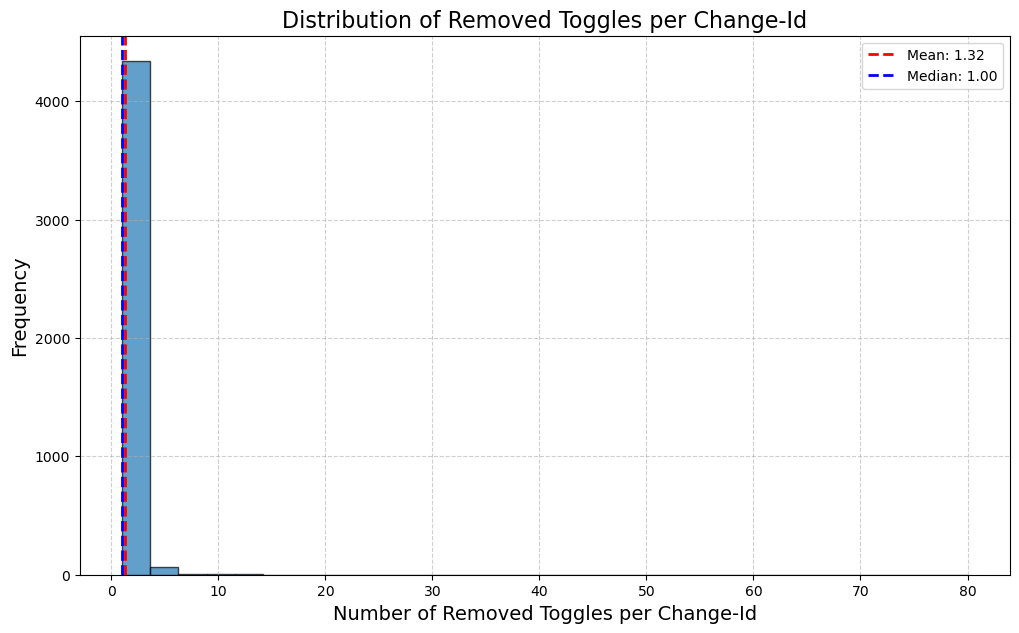

In [45]:
import re

df_removed = df.dropna(subset=['commit_id_removed'])

# Improved function to extract Change-Id
def extract_change_id(commit_message):
    if pd.isna(commit_message):
        return None  # Handle NaN values safely

    commit_message = commit_message.strip()  # Remove leading/trailing spaces
    match = re.search(r'(?i)Change-Id:\s*([\w\d]+)', commit_message)  # Case-insensitive, flexible spacing

    if match:
        return match.group(1)
    else:
        #print(f"No Change-Id found in message: {commit_message}...")  # Print first 200 chars for debugging
        return None
    
    
# Apply extraction
df_removed['change_id_removed'] = df_removed['commit_message_removed'].apply(extract_change_id)

# Check how many Change-Ids were found
print(df_removed['change_id_removed'].dropna().head(10))

print(len(df_removed))
# Remove rows where change_id_removed is null (i.e., Change-Id was not found)
df_removed = df_removed.dropna(subset=['change_id_removed'])

print(len(df_removed))

# Count the number of removed toggles per Change-Id
removed_toggles_per_change_id = df_removed.groupby('change_id_removed').size().reset_index(name='removed_toggles')

print(len(removed_toggles_per_change_id))

# Compute summary statistics
removed_toggles_change_id_stats = {
    "Mean": removed_toggles_per_change_id['removed_toggles'].mean(),
    "Median": removed_toggles_per_change_id['removed_toggles'].median(),
    "Min": removed_toggles_per_change_id['removed_toggles'].min(),
    "Max": removed_toggles_per_change_id['removed_toggles'].max(),
    "Changes with Multiple Removals": (removed_toggles_per_change_id['removed_toggles'] >=20).sum()
}

# Display the updated summary statistics
removed_toggles_change_id_stats_df = pd.DataFrame.from_dict(removed_toggles_change_id_stats, orient='index', columns=['Value'])
print(removed_toggles_change_id_stats_df)

# Plot the distribution of removed toggles per Change-Id
plt.figure(figsize=(12, 7))
plt.hist(removed_toggles_per_change_id['removed_toggles'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(removed_toggles_per_change_id['removed_toggles'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {removed_toggles_per_change_id['removed_toggles'].mean():.2f}")
plt.axvline(removed_toggles_per_change_id['removed_toggles'].median(), color='blue', linestyle='dashed', linewidth=2, label=f"Median: {removed_toggles_per_change_id['removed_toggles'].median():.2f}")

# Formatting the plot
plt.xlabel("Number of Removed Toggles per Change-Id", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Removed Toggles per Change-Id", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()
